# Data Preprocessing - imputation by analyzing by semantically similar groups of factors

In this notebook, we attempt to conduct data imputation by analyzing the factors that are semantically similar to each other, and check if they are interchangable or not. 

The google docs for the similar factors is shown [here](https://docs.google.com/document/d/1iSZYiolLmyTKLHlo-tGlhpErKTOPJA4T72hZgv4QA5w/edit?usp=sharing)


Specifically, the data imputation consists of two steps:
1. Check the colinearity among semantically-similar columns
2. If we observe a certain level of colinearity, check if their raw values, or the normalized values are interchanagable.

# 0. Data & Package Import & Function Definition

We first import necessary packages and data

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from numpy.linalg import eigvals

Then, we define necessary functions:
- **analyze_columns**: check multicolinearity
    - correlation matrix
    - eigenvalues
    - condition number
    - VIFs
- **normalized_difference**: check interchangability of normalized values.

In [29]:
df = pd.read_csv('../database/2016-2022.csv')

/var/folders/kw/6hnl881s2p9701b42gpjt_pr0000gn/T/ipykernel_1148/1726423081.py:1: DtypeWarning: Columns (7,8,64,66,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../database/2016-2022.csv')


In [63]:
# 1. multicolinearity test: correlation matrix, eigenvalues, condition number, and VIFs
def analyze_columns(df, cols, labels=None):
    # Drop rows with NaN or inf values in the specified columns
    df_clean = df[cols].replace([np.inf, -np.inf], np.nan).dropna(subset=cols)
    
    # 1. Correlation matrix heatmap
    print("1. Correlation matrix")
    corr = df_clean[cols].corr()
    
    if not labels:
        labels = cols

    plt.figure(figsize=(4, 4))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, xticklabels=labels, yticklabels=labels)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

    # 2. Eigenvalues
    eigenvalues = eigvals(corr)
    print(f"\n2. Eigenvalues: {eigenvalues}\n")

    # 3. Condition number
    condition_number = np.sqrt(eigenvalues.max() / eigenvalues.min())
    print(f"3. Condition Number: {condition_number}\n")

    # 4. VIF
    print("4. VIF:")
    X = df_clean[cols].assign(const=1)  # adding a constant for the intercept
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)
    print("\n" + "-"*50 + "\n")


def normalized_difference(df, col1, col2):
    # Normalize the values of col1 and col2
    df[f'{col1}_normalized'] = (df[col1] - df[col1].mean()) / df[col1].std()
    df[f'{col2}_normalized'] = (df[col2] - df[col2].mean()) / df[col2].std()

    # Compute the difference between the two normalized values
    df['difference_normalized'] = df[f'{col1}_normalized'] - df[f'{col2}_normalized']

    # Drop rows where either col1_normalized, col2_normalized, or difference_normalized is NaN or infinite
    df_clean_normalized = df.dropna(subset=[f'{col1}_normalized', f'{col2}_normalized', 'difference_normalized'])
    df_clean_normalized = df_clean_normalized[np.isfinite(df_clean_normalized['difference_normalized'])]

    # Plotting
    plt.figure(figsize=(4, 4))
    sns.histplot(df_clean_normalized['difference_normalized'], bins=100, kde=True, color='skyblue', edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of Difference between Normalized {col1} and {col2}')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Summary statistics for normalized values
    mean_diff_normalized = df_clean_normalized['difference_normalized'].mean()
    std_diff_normalized = df_clean_normalized['difference_normalized'].std()
    conf_interval_normalized = stats.t.interval(0.95, len(df_clean_normalized['difference_normalized'])-1, loc=mean_diff_normalized, scale=std_diff_normalized/np.sqrt(len(df_clean_normalized['difference_normalized'])))

    # Print correlation
    correlation = df[col1].corr(df[col2])
    print(f"Correlation between {col1} and {col2}: {correlation:.6f}")
    
    # Print summary statistics
    print(f"\nMean Difference (Normalized): {mean_diff_normalized:.6f}")
    print(f"Standard Deviation (Normalized): {std_diff_normalized:.6f}")
    print(f"95% Confidence Interval (Normalized): ({conf_interval_normalized[0]:.6f}, {conf_interval_normalized[1]:.6f})")


# 1. total_return_##

The **total_return_##** field is shown below:
- total_return_5y
- total_return_4y
- total_return_3y
- total_return_2y
- total_return_1y
- total_return_6m
- total_return_3m

## 1.1 Check colinearity

We do 4 things as shown below in order to check multicolinearity:
1. Correlation matrix heatmap
2. Eigenvalues of the correlation matrix (very small eigenvalues indicate the presence of multicollinearity)
3. Condition number of the correlation matrix (A large condition number indicates multicollinearity)
4. VIF (a VIF above 5-10 indicates a problematic amount of collinearity)

1. Correlation matrix


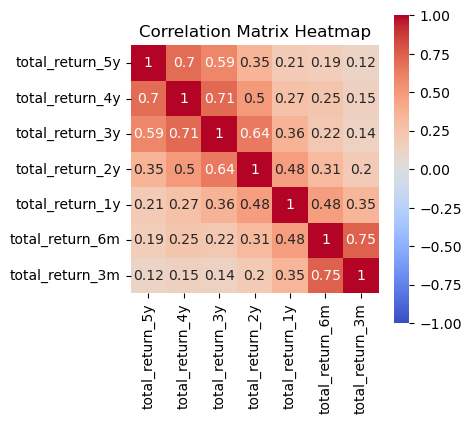


2. Eigenvalues: [3.32722128 1.60268312 0.81037339 0.48985179 0.29352075 0.25697401
 0.21937567]

3. Condition Number: 3.8944543397582887

4. VIF:
          Variable       VIF
0  total_return_5y  2.038341
1  total_return_4y  2.742192
2  total_return_3y  2.793333
3  total_return_2y  1.977232
4  total_return_1y  1.549863
5  total_return_6m  2.668100
6  total_return_3m  2.287625
7            const  1.195109

--------------------------------------------------



In [52]:
cols = ['total_return_5y','total_return_4y','total_return_3y','total_return_2y','total_return_1y','total_return_6m','total_return_3m']
analyze_columns(df, cols)

To conclude:
1. Neighbouring return values have high correlations in the range of roughly 0.5~0.7
2. Eigenvalues are pretty small but not sure of the thresholds
3. Condition number is 4, which is moderate
4. VIF values for all the variables is below 5, which is on the acceptable level.

As we observe a certain level of correlations among the neighboring values, we check the distribution of the differences. 

## 1.2 Check interchangability

### 1.2.1 total_return_5y, total_return_4y

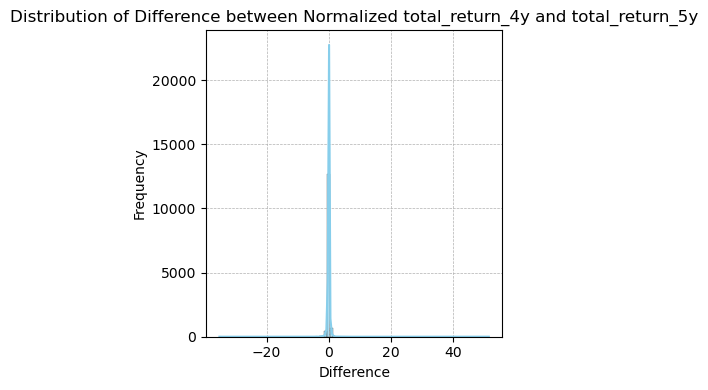

Correlation between total_return_4y and total_return_5y: 0.698168

Mean Difference (Normalized): 0.003382
Standard Deviation (Normalized): 0.782765
95% Confidence Interval (Normalized): (-0.009575, 0.016339)


In [64]:
normalized_difference(df, 'total_return_4y', 'total_return_5y')

### 1.2.2 total_return_4y, total_return_3y

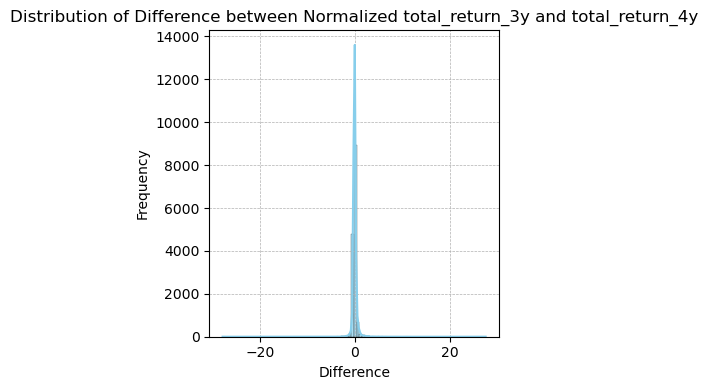

Correlation between total_return_3y and total_return_4y: 0.719833

Mean Difference (Normalized): 0.007524
Standard Deviation (Normalized): 0.750573
95% Confidence Interval (Normalized): (-0.004490, 0.019538)


In [66]:
normalized_difference(df, 'total_return_3y', 'total_return_4y')

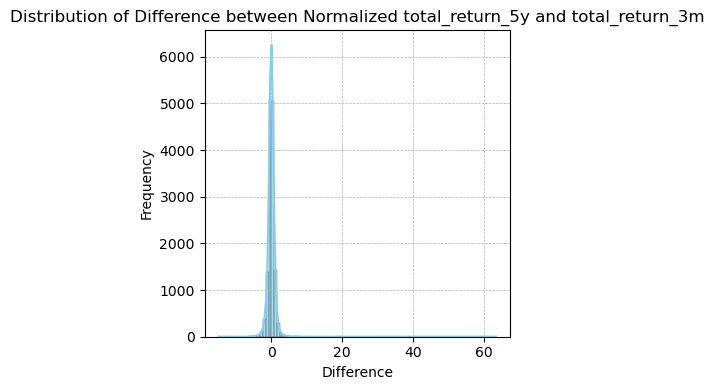

Correlation between total_return_5y and total_return_3m: 0.117633

Mean Difference (Normalized): -0.035961
Standard Deviation (Normalized): 1.243214
95% Confidence Interval (Normalized): (-0.056519, -0.015404)


In [68]:
normalized_difference(df, 'total_return_5y', 'total_return_3m')

# 2. capex & net_capex

There are two variables related to capital expenditure
- capexï¼šcapital expenditure: cash used for the acquistion of assets like property, plant and equipment
- net_capex: capex - proceeds from the sale of long-term assets

## 2.1 Check colinearity

1. Correlation matrix


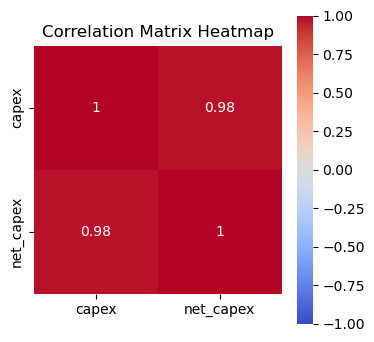


2. Eigenvalues: [1.9763111 0.0236889]

3. Condition Number: 9.133877099066106

4. VIF:
    Variable        VIF
0      capex  21.359924
1  net_capex  21.359924
2      const   1.058887

--------------------------------------------------



In [32]:
# Analyzing 'capex' and 'net_capex' columns
cols = ['capex', 'net_capex']
analyze_columns(df, cols)

To conclude:
1. It has a extremely high correlation (0.98)
2. Eigenvalues are pretty small, especially the second eigenvalue is 0.02
3. Condition number is 9, which is pretty big
4. VIF values for all the variables is 21, which is very hight.

Therefore, we may decide to drop one of the 2 columns.
Also, I did a basic visualization to check the correlation. 

df has columns 'capex' and 'net_capex'. Plot a dot plot with capex on the x-axis and net_capex on the y-axis

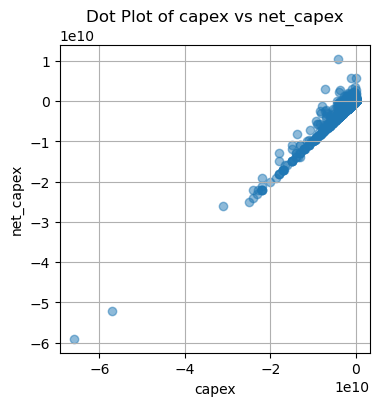

In [6]:
# Scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(df['capex'], df['net_capex'], alpha=0.5)
plt.title('Dot Plot of capex vs net_capex')
plt.xlabel('capex')
plt.ylabel('net_capex')
plt.grid(True)
plt.show()

Then, we check which column has more NaN values. 

In [21]:
total_rows = len(df)
capex_na_count = df['capex'].isna().sum()
net_capex_na_count = df['net_capex'].isna().sum()
both_not_missing = df.dropna(subset=['capex', 'net_capex']).shape[0]
only_net_capex_missing = df[df['capex'].notna() & df['net_capex'].isna()].shape[0]
only_capex_missing = df[df['capex'].isna() & df['net_capex'].notna()].shape[0]
both_missing = df[df['capex'].isna() & df['net_capex'].isna()].shape[0]
print(f"Number of rows where capex is missing: {capex_na_count}")
print(f"Number of rows where net_capex is missing: {net_capex_na_count}")
print(f"Number of rows where both are not missing: {both_not_missing}")
print(f"Number of rows where only net_capex is missing: {only_net_capex_missing}")
print(f"Number of rows where only capex is missing: {only_capex_missing}")
print(f"Number of rows where both are missing: {both_missing}")

Number of rows where capex is missing: 781
Number of rows where net_capex is missing: 1218
Number of rows where both are not missing: 16986
Number of rows where only net_capex is missing: 446
Number of rows where only capex is missing: 9
Number of rows where both are missing: 772


Seems like there are only 9 cases where only **capex** is missing with there are 445 cases where only **net_capex** is missing. Therefore, we priotize **capex** over **net_capex**

## 2.2. Check Interchangability

There are lots of cases where capex values and net_capex values are similar to each other. Therefore, we statistically check if it is available to substitute the missing values of capex to the ones of net_capex. We compute the quotient between net_capex and capex, and check the distribution as well as the confidence interval

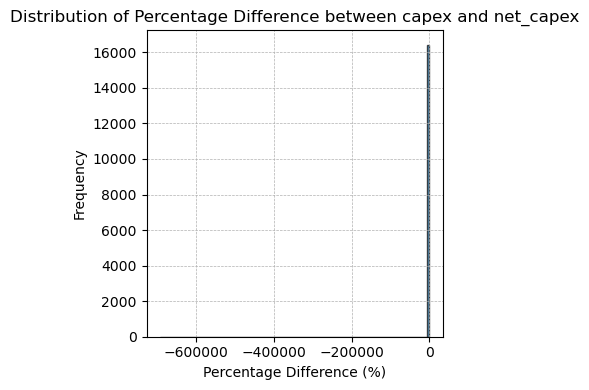

Mean Percentage Difference: -137.91%
Standard Deviation: 6859.89%
95% Confidence Interval: (-242.81%, -33.02%)


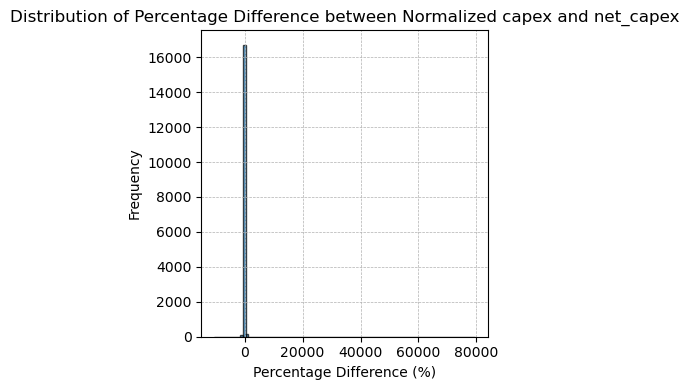

Mean Percentage Difference (Normalized): -6.50%
Standard Deviation (Normalized): 684.19%
95% Confidence Interval (Normalized): (-16.79%, 3.79%)


In [24]:
compute_difference(df, 'capex', 'net_capex')
compute_difference_normalized(df, 'capex', 'net_capex')

According to what shown above, it seems like there is a significant difference in values between **capex** and **net_capex**. However, when it is normalized, 

In [26]:
df['capex_normalized']

0        0.002595
1       -2.183450
2        0.228039
3        0.189970
4        0.229716
           ...   
18208    0.148804
18209    0.212185
18210    0.221767
18211    0.222477
18212    0.229346
Name: capex_normalized, Length: 18213, dtype: float64

## 3. Working capital

There are 3 types of working capital:
- short_term_wc: current assets - current liabilities
- long_term_wc: non-current assets - non-current liabilities
- modified_wc: While standard working capital is calculated as current assets minus current liabilities, the modified working capital might exclude certain items from this calculation based on specific context or industry. (e.g. short-term debt or cash might be excluded to get a clearer picture of operational liquidity)

We conduct the same analysis as shown below:

## 3.1 colinearity test

1. Correlation matrix


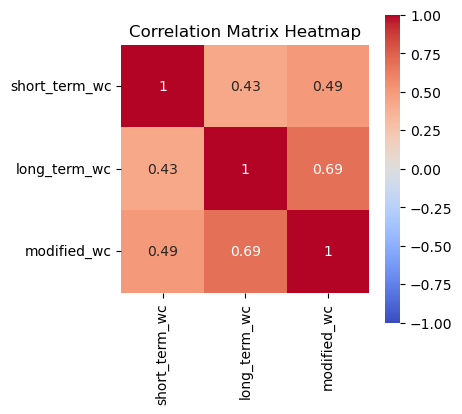


2. Eigenvalues: [2.07765919 0.61334373 0.30899709]

3. Condition Number: 2.5930444489980213

4. VIF:
        Variable       VIF
0  short_term_wc  1.347817
1   long_term_wc  1.921112
2    modified_wc  2.079065
3          const  1.085875

--------------------------------------------------



In [9]:
cols = ['short_term_wc', 'long_term_wc','modified_wc']
analyze_columns(df, cols)

According to the results above:
1. There is a meaningful correlation among them, especially the one of **long_term_wc** and **modified_wc**, which is 0.69.
2. Eigenvalues are moderately small, but both the condition number and VIFs are in the acceptable level. 

Therefore, there is no enough evidence to drop a single one among them. 

## 3.2 Missing values counting

In [10]:
total_rows = len(df)
short_term_missing = df['short_term_wc'].isna().sum()
short_term_percentage = (short_term_missing / total_rows) * 100
long_term_missing = df['long_term_wc'].isna().sum()
long_term_percentage = (long_term_missing / total_rows) * 100
modified_missing = df['modified_wc'].isna().sum()
modified_percentage = (modified_missing / total_rows) * 100
only_short_term_missing = df[df['short_term_wc'].isna() & df['long_term_wc'].notna() & df['modified_wc'].notna()].shape[0]
only_short_term_percentage = (only_short_term_missing / total_rows) * 100
only_long_term_missing = df[df['short_term_wc'].notna() & df['long_term_wc'].isna() & df['modified_wc'].notna()].shape[0]
only_long_term_percentage = (only_long_term_missing / total_rows) * 100
only_modified_missing = df[df['short_term_wc'].notna() & df['long_term_wc'].notna() & df['modified_wc'].isna()].shape[0]
only_modified_percentage = (only_modified_missing / total_rows) * 100
short_and_long_missing = df[df['short_term_wc'].isna() & df['long_term_wc'].isna() & df['modified_wc'].notna()].shape[0]
short_and_long_percentage = (short_and_long_missing / total_rows) * 100
short_and_modified_missing = df[df['short_term_wc'].isna() & df['long_term_wc'].notna() & df['modified_wc'].isna()].shape[0]
short_and_modified_percentage = (short_and_modified_missing / total_rows) * 100
long_and_modified_missing = df[df['short_term_wc'].notna() & df['long_term_wc'].isna() & df['modified_wc'].isna()].shape[0]
long_and_modified_percentage = (long_and_modified_missing / total_rows) * 100
all_missing = df[df['short_term_wc'].isna() & df['long_term_wc'].isna() & df['modified_wc'].isna()].shape[0]
all_missing_percentage = (all_missing / total_rows) * 100
print(f"Rows where 'short_term_wc' is missing: {short_term_missing} ({short_term_percentage:.2f}%)")
print(f"Rows where 'long_term_wc' is missing: {long_term_missing} ({long_term_percentage:.2f}%)")
print(f"Rows where 'modified_wc' is missing: {modified_missing} ({modified_percentage:.2f}%)")
print("")
print(f"Rows where only 'short_term_wc' is missing: {only_short_term_missing} ({only_short_term_percentage:.2f}%)")
print(f"Rows where only 'long_term_wc' is missing: {only_long_term_missing} ({only_long_term_percentage:.2f}%)")
print(f"Rows where only 'modified_wc' is missing: {only_modified_missing} ({only_modified_percentage:.2f}%)")
print(f"Rows where only 'short_term_wc' and 'long_term_wc' are missing: {short_and_long_missing} ({short_and_long_percentage:.2f}%)")
print(f"Rows where only 'short_term_wc' and 'modified_wc' are missing: {short_and_modified_missing} ({short_and_modified_percentage:.2f}%)")
print(f"Rows where only 'long_term_wc' and 'modified_wc' are missing: {long_and_modified_missing} ({long_and_modified_percentage:.2f}%)")
print(f"Rows where all of them are missing: {all_missing} ({all_missing_percentage:.2f}%)")


Rows where 'short_term_wc' is missing: 5475 (30.06%)
Rows where 'long_term_wc' is missing: 4655 (25.56%)
Rows where 'modified_wc' is missing: 4293 (23.57%)

Rows where only 'short_term_wc' is missing: 805 (4.42%)
Rows where only 'long_term_wc' is missing: 0 (0.00%)
Rows where only 'modified_wc' is missing: 20 (0.11%)
Rows where only 'short_term_wc' and 'long_term_wc' are missing: 397 (2.18%)
Rows where only 'short_term_wc' and 'modified_wc' are missing: 15 (0.08%)
Rows where only 'long_term_wc' and 'modified_wc' are missing: 0 (0.00%)
Rows where all of them are missing: 4258 (23.38%)


As shown:
1. Most of the missing data come from the same rows (4258 rows, 23.38%), therefore, substitution doesn't seem to be among these 3 fields for these rows. 
2. There is a significant amount of portion where **short_term_wc** is alone missing. We check whether substitution for these rows.  

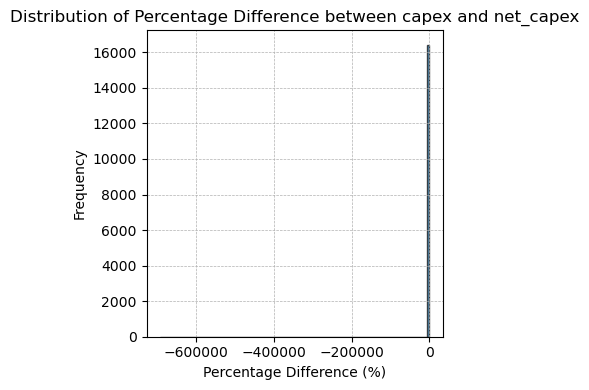

Mean Percentage Difference: -137.91%
Standard Deviation: 6859.89%
95% Confidence Interval: (-242.81%, -33.02%)


In [12]:
# Compute the difference between the two values over capex, avoiding division by zero
df['difference_pct'] = np.where(df['capex'] != 0, (df['net_capex'] - df['capex']) / df['capex'] * 100, np.nan)

# Drop rows where either capex, net_capex, or difference_pct is NaN or infinite
df_clean = df.dropna(subset=['capex', 'net_capex', 'difference_pct'])
df_clean = df_clean[np.isfinite(df_clean['difference_pct'])]

# Plotting the distribution of the difference
plt.figure(figsize=(4, 4))
plt.hist(df_clean['difference_pct'], bins=100, edgecolor='k', alpha=0.7)
plt.title('Distribution of Percentage Difference between capex and net_capex')
plt.xlabel('Percentage Difference (%)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Compute and display summary statistics
mean_diff = df_clean['difference_pct'].mean()
std_diff = df_clean['difference_pct'].std()
conf_interval = stats.t.interval(0.95, len(df_clean['difference_pct'])-1, loc=mean_diff, scale=std_diff/np.sqrt(len(df_clean['difference_pct'])))

print(f"Mean Percentage Difference: {mean_diff:.2f}%")
print(f"Standard Deviation: {std_diff:.2f}%")
print(f"95% Confidence Interval: ({conf_interval[0]:.2f}%, {conf_interval[1]:.2f}%)")

# Do the same thing for short_term_wc and long_term_wc, short_term_wc and modified_wc, and long_term_wc & modified_wc. Plot the 3 graphs horizontally


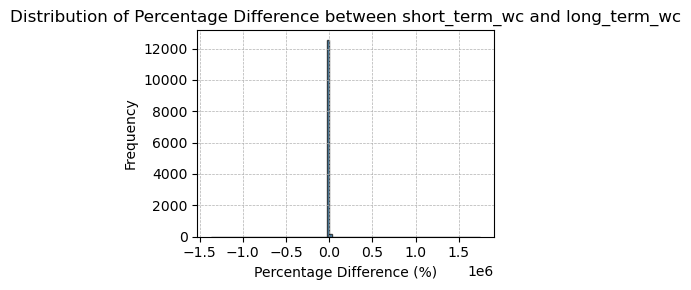

For short_term_wc and long_term_wc:
Mean Percentage Difference: 56.82%
Standard Deviation: 23366.47%
95% Confidence Interval: (-349.00%, 462.64%)

--------------------------------------------------


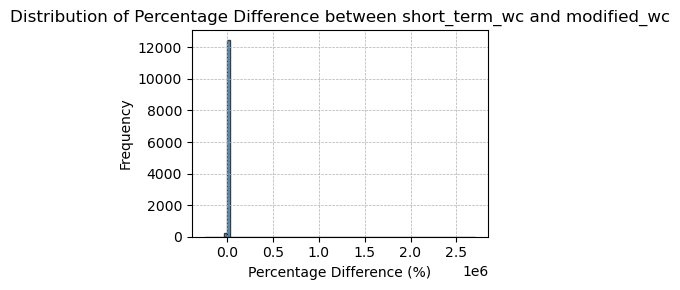

For short_term_wc and modified_wc:
Mean Percentage Difference: 243.50%
Standard Deviation: 24469.26%
95% Confidence Interval: (-181.81%, 668.80%)

--------------------------------------------------


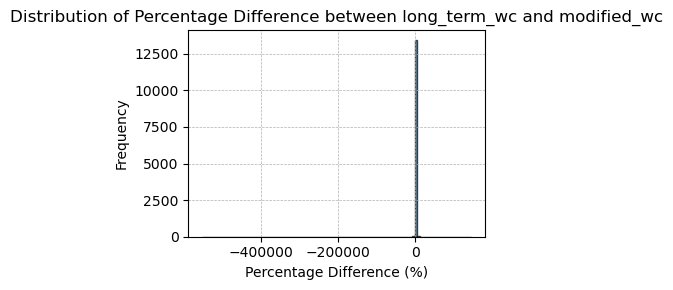

For long_term_wc and modified_wc:
Mean Percentage Difference: -71.68%
Standard Deviation: 5389.09%
95% Confidence Interval: (-162.52%, 19.16%)

--------------------------------------------------


In [13]:
def compare_columns(df, col1, col2):
    # Compute the difference between the two columns, avoiding division by zero
    difference_col = f'difference_{col1}_{col2}'
    df[difference_col] = np.where(df[col1] != 0, (df[col2] - df[col1]) / df[col1] * 100, np.nan)

    # Drop rows where either column or difference is NaN or infinite
    df_clean = df.dropna(subset=[col1, col2, difference_col])
    df_clean = df_clean[np.isfinite(df_clean[difference_col])]

    # Plotting the distribution of the difference
    plt.figure(figsize=(4, 3))
    plt.hist(df_clean[difference_col], bins=100, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of Percentage Difference between {col1} and {col2}')
    plt.xlabel('Percentage Difference (%)')
    plt.ylabel('Frequency')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Compute and display summary statistics
    mean_diff = df_clean[difference_col].mean()
    std_diff = df_clean[difference_col].std()
    conf_interval = stats.t.interval(0.95, len(df_clean[difference_col])-1, loc=mean_diff, scale=std_diff/np.sqrt(len(df_clean[difference_col])))

    print(f"For {col1} and {col2}:")
    print(f"Mean Percentage Difference: {mean_diff:.2f}%")
    print(f"Standard Deviation: {std_diff:.2f}%")
    print(f"95% Confidence Interval: ({conf_interval[0]:.2f}%, {conf_interval[1]:.2f}%)\n")
    print("-" * 50)

# Compare the columns
compare_columns(df, 'short_term_wc', 'long_term_wc')
compare_columns(df, 'short_term_wc', 'modified_wc')
compare_columns(df, 'long_term_wc', 'modified_wc')


As shown above, for all the combinations of 2 factors among these 3, the 95% CI covers 0. However, the absolute values of mean percentage values seem to be very high such that it never seems to be fine for interchange.

### **ISSUE**: What if we convert into the percentile and then check it again?
- When we convert the column into percentile, we fit the column values into a straight monolinear model.
- This may neglect the structure behind each column, but makes the values more interchangable. 

# 4. ebit, ebitda, net_income, net_revenue

- EBIT = Revenue - Operating Expenses
- EBITDA = EBIT + Depreciation + Amortization
- net income =  EBIT - Interest - taxes
- net revenue = EBITDA + Operating expenses (excluding interest, taxes, depreciation, and amortization = Gross Revenue - returns allowance - discounts



## 4.1 colinearity test

1. Correlation matrix


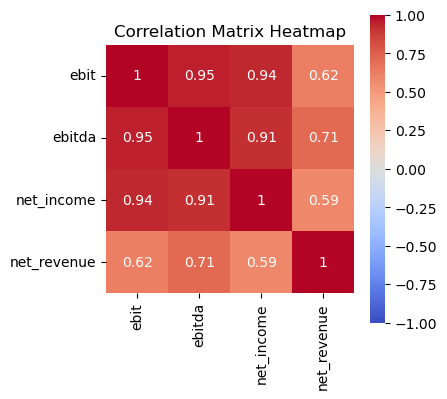


2. Eigenvalues: [3.37779577 0.50277436 0.03680857 0.0826213 ]

3. Condition Number: 9.57948679683322

4. VIF:
      Variable        VIF
0         ebit  16.353977
1       ebitda  14.648267
2   net_income   8.356210
3  net_revenue   2.197566
4        const   1.094316

--------------------------------------------------



In [14]:
cols = ['ebit', 'ebitda','net_income','net_revenue']
analyze_columns(df, cols)

As shown above:
1. There are extremely high correlations among ebitda, ebit, and net_income (~0.9)
2. There is a considerable correlation between net_revenue and other 3 factors too. (0.6~0.7)
3. Eigenvalues are small and condition number is big. Indicate a high colinearity.
4. Extremely high VIFs for ebit, ebitda, and net_revenue, giving another proof of high colinearity among them

## 4.2. Percentage difference

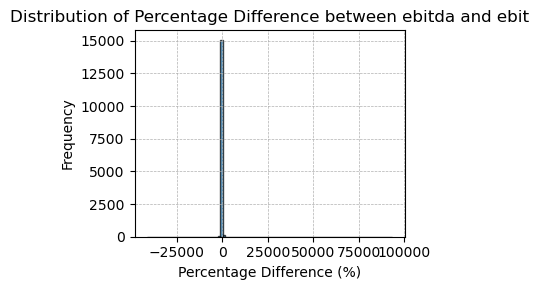

For ebitda and ebit:
Mean Percentage Difference: -20.19%
Standard Deviation: 1142.43%
95% Confidence Interval: (-38.30%, -2.08%)

--------------------------------------------------


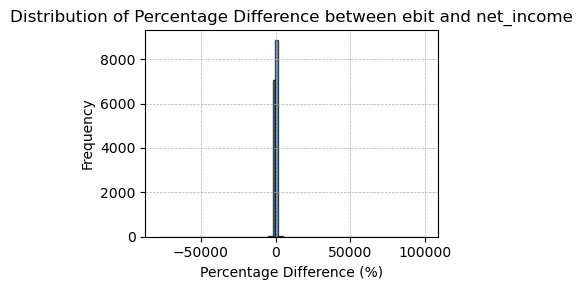

For ebit and net_income:
Mean Percentage Difference: -40.65%
Standard Deviation: 1392.11%
95% Confidence Interval: (-62.19%, -19.11%)

--------------------------------------------------


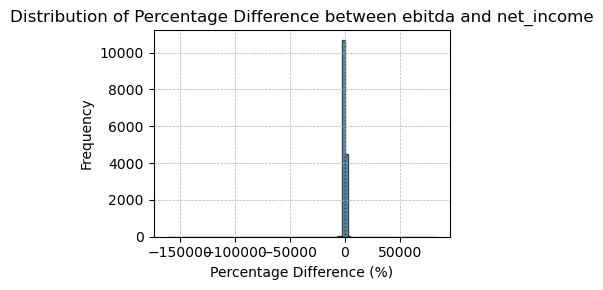

For ebitda and net_income:
Mean Percentage Difference: -62.85%
Standard Deviation: 1991.09%
95% Confidence Interval: (-94.46%, -31.25%)

--------------------------------------------------


In [15]:
# Compare the columns
compare_columns(df, 'ebitda', 'ebit')
compare_columns(df, 'ebit', 'net_income')
compare_columns(df, 'ebitda', 'net_income')

# 5. ebitda_margin, operating_margin

# 6. rsi_14d, rsi_30d

# 7. volatility_30d, volatility_90d, volatility_180d

# 8. normalized_roe, headline_roe, operating_roe

# 9. eps_adjusted_diluted, eps_gaap-diluted, eps_adjusted_headline, eps_adjusted_basic

# 10. fcf_to_equity, headline_fcf, unlevered_fcf

# 11. repurchase, net_repurchase

# 12. dividend_per_share, dividend_to_common, dividend_to_preferred, dividend_payout_ratio

# 13. total_compensation_to_executives, total_compensation_to_board_members

In [ ]:
# Sort the 'market_cap' values in ascending order
sorted_market_cap = df['market_cap'].sort_values().dropna()

# Generate x values representing the sorted order
x_values = range(len(sorted_market_cap))

# Plotting the graph of sorted_market_cap
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_values, sorted_market_cap)
plt.title('Graph of market_cap (Ascending Order)')
plt.xlabel('Sorted Order')
plt.ylabel('market_cap')

# Plotting the graph of log(sorted_market_cap)
plt.subplot(1, 2, 2)
plt.plot(x_values, np.log(sorted_market_cap))
plt.title('Graph of log(market_cap) (Ascending Order)')
plt.xlabel('Sorted Order')
plt.ylabel('log(market_cap)')

plt.tight_layout()
plt.show()
